In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import sys
sys.path.append("../")
import ionopy
from ionopy import MadrigalDatasetTimeSeries, weight_init, mae_loss


import pandas as pd
import torch
from omegaconf import OmegaConf
from tft_torch import tft
import tft_torch.loss as tft_loss
import torch.nn.init as init
import numpy as np
import wandb
from pyfiglet import Figlet
from termcolor import colored
from tqdm import tqdm

from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
import random




In [ ]:
model_path = '/home/ga00693/Develop/2025-HL-Ionosphere/scripts/tft_model_best.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using: ", device)
torch_type=torch.float32

bucket_dir='/home/ga00693/gcs-bucket'
config={'madrigal_path': f'{bucket_dir}/madrigal_data/processed/gps_data_tarr/csv_subsets/subset_tec_5mln.csv',
        'set_sw_path': f'{bucket_dir}/karman-2025/data/sw_data/set_sw.csv',
        'celestrack_path': f'{bucket_dir}/karman-2025/data/sw_data/celestrack_sw.csv',
        'omni_indices_path': f'{bucket_dir}/karman-2025/data/omniweb_data/merged_omni_indices.csv',
        'omni_magnetic_field_path': f'{bucket_dir}/karman-2025/data/omniweb_data/merged_omni_magnetic_field.csv',
        'omni_solar_wind_path': f'{bucket_dir}/karman-2025/data/omniweb_data/merged_omni_solar_wind.csv',
        'jpld_path': f'{bucket_dir}/jpld/subset_lat_lon/jpld_vtec_15min.csv',
        'use_celestrack': True,
        'use_set_sw': True,
        'use_jpld': True,
        'use_omni_indices': True,
        'use_omni_magnetic_field': True,
        'use_omni_solar_wind': True,
        'lag_days_proxies':144, # 81 days
        'proxies_resolution':1,  # 1 day
        'lag_minutes_omni':8640,  # 2880 minutes (2 days)
        'omni_resolution':60,  # 1 minute
        'lag_minutes_jpld':8640,  # 2880 minutes (2 days)
        'jpld_resolution':60,  # 1 minute
}
madrigal_dataset = MadrigalDatasetTimeSeries(config,
                                            torch_type=torch_type)


Using:  cuda

MadrigalDatasetTimeSeries initialized with min_date: 2010-06-13 00:00:00 and max_date: 2024-07-31 23:45:00
Loading Madrigal dataset with config:
 {'madrigal_path': '/home/ga00693/gcs-bucket/madrigal_data/processed/gps_data_tarr/csv_subsets/subset_tec_5mln.csv', 'set_sw_path': '/home/ga00693/gcs-bucket/karman-2025/data/sw_data/set_sw.csv', 'celestrack_path': '/home/ga00693/gcs-bucket/karman-2025/data/sw_data/celestrack_sw.csv', 'omni_indices_path': '/home/ga00693/gcs-bucket/karman-2025/data/omniweb_data/merged_omni_indices.csv', 'omni_magnetic_field_path': '/home/ga00693/gcs-bucket/karman-2025/data/omniweb_data/merged_omni_magnetic_field.csv', 'omni_solar_wind_path': '/home/ga00693/gcs-bucket/karman-2025/data/omniweb_data/merged_omni_solar_wind.csv', 'jpld_path': '/home/ga00693/gcs-bucket/jpld/subset_lat_lon/jpld_vtec_15min.csv', 'use_celestrack': True, 'use_set_sw': True, 'use_jpld': True, 'use_omni_indices': True, 'use_omni_magnetic_field': True, 'use_omni_solar_wind': T

Madrigal data loaded with shape: (4537573, 5)
Now removing 0 TEC values...
Madrigal data processed, final shape: (4536735, 5)
Input features shape: torch.Size([4536735, 7])

Loading JPLD dataset.
Loading time series data for jpld
Normalizing time series data for jpld

Loading Omni indices.
Loading time series data for omni_indices
Normalizing time series data for omni_indices

Loading Omni Solar Wind.
Loading time series data for omni_solar_wind
Normalizing time series data for omni_solar_wind

Loading Omni Magnetic Field.
Loading time series data for omni_magnetic_field
Normalizing time series data for omni_magnetic_field

Loading SET Solar Wind data.
Normalizing time series data for set_sw

Loading Celestrack data.
Normalizing time series data for celestrack


In [6]:

# set configuration
num_historical_numeric=0

if madrigal_dataset.config['omni_indices_path'] is not None:
    num_historical_numeric+=madrigal_dataset[0]['omni_indices'].shape[1]
if madrigal_dataset.config['omni_magnetic_field_path'] is not None:
    num_historical_numeric+=madrigal_dataset[0]['omni_magnetic_field'].shape[1]
if madrigal_dataset.config['omni_solar_wind_path'] is not None:
    num_historical_numeric+=madrigal_dataset[0]['omni_solar_wind'].shape[1]
if madrigal_dataset.config['celestrack_path'] is not None:
    num_historical_numeric+=madrigal_dataset[0]['celestrack'].shape[1]
if madrigal_dataset.config['set_sw_path'] is not None:
    num_historical_numeric+=madrigal_dataset[0]['set_sw'].shape[1]
if madrigal_dataset.config['jpld_path'] is not None:
    num_historical_numeric+=madrigal_dataset[0]['jpld'].shape[1]

print(f"Historical input features of the model: {num_historical_numeric}")

input_dimension=len(madrigal_dataset[0]['inputs'])
print(f"Static features of the model: {input_dimension}")

if num_historical_numeric==0:
    raise ValueError('No historical numeric data found in the dataset')

data_props = {'num_historical_numeric': num_historical_numeric,
            'num_static_numeric': input_dimension,
            'num_future_numeric': 1,
            }

configuration = {
                'model':
                    {
                        'dropout': 0.1,
                        'state_size': 64,
                        'output_quantiles': [0.5], #[0.1, 0.5, 0.9],
                        'lstm_layers': 2,
                        'attention_heads': 4,
                    },
                'task_type': 'regression',
                'target_window_start': None,
                'data_props': data_props,
                }
# initialize TFT model 
ts_ionopy_model = tft.TemporalFusionTransformer(OmegaConf.create(configuration))
# weight init
#ts_ionopy_model.apply(weight_init)

Historical input features of the model: 40
Static features of the model: 7


In [ ]:
ts_ionopy_model.to(device)
print(f"Loading Ionopy model from {model_path}")
ts_ionopy_model.load_state_dict(torch.load(model_path,map_location=device))

num_params=sum(p.numel() for p in ts_ionopy_model.parameters() if p.requires_grad)
print(f'Ionopy model num parameters: {num_params}')


Loading Ionopy model from /home/ga00693/Develop/2025-HL-Ionosphere/scripts/tft_model_best.pth
Ionopy model num parameters: 1433093


/var/tmp/ipykernel_2565070/1021642389.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ts_ionopy_model.load_state_dict(torch.load(model_path,map_location=device))


In [9]:
idx_test_fold=2
test_month_idx = 2 * (idx_test_fold - 1)
validation_month_idx = test_month_idx + 2
print(test_month_idx,validation_month_idx)
madrigal_dataset._set_indices(test_month_idx=[test_month_idx], validation_month_idx=[validation_month_idx],custom={ 2012: {"validation":8, "test":9},
                                                                                                                    2013: {"validation":4, "test":5},
                                                                                                                    2015: {"validation":2, "test":3},#geomag storm
                                                                                                                    2019: {"validation":6, "test":10},#quiet period
                                                                                                                    2022: {"validation":0, "test":1},
                                                                                                                    2024: {"validation":4,"test":5}})
train_dataset = madrigal_dataset.train_dataset()
validation_dataset = madrigal_dataset.validation_dataset()
test_dataset = madrigal_dataset.test_dataset()


2 4
Creating training, validation and test sets.


15 years to iterate through.: 100%|██████████| 15/15 [00:04<00:00,  3.17it/s]

Train size: 3639777
Validation size: 356025
Test size: 388320


In [11]:
train_sampler = RandomSampler(train_dataset, num_samples=len(train_dataset))
validation_sampler = RandomSampler(validation_dataset, num_samples=len(validation_dataset))
test_sampler = SequentialSampler(test_dataset)

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25,50,75,100,125,150,175,200,225,230,240,250,260,270], gamma=0.8, verbose=False)
criterion=torch.nn.MSELoss()

seed=0
batch_size=256
num_workers=24

# And the dataloader
#seed them
g = torch.Generator()
g.manual_seed(0)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    pin_memory=True,
    num_workers=num_workers,
    sampler=train_sampler,
    drop_last=True,
    generator=g
)
validation_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=batch_size,
    pin_memory=True,
    num_workers=num_workers,
    sampler=validation_sampler,
    drop_last=True,
    generator=g
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    pin_memory=True,
    num_workers=num_workers,
    sampler=test_sampler,
    drop_last=True,
    generator=g
)


In [ ]:
criterion=torch.nn.MSELoss()
quantiles_tensor= torch.tensor([0.5], dtype=torch_type, device=device)  # For TFT, we use the median quantile


ts_ionopy_model.eval()
with torch.no_grad():
    test_loss = 0.
    test_rmse_loss_unnormalized = 0.
    test_mae_unnormalized = 0.
    count = 0
    test_rmses = []
    for batch in tqdm(test_loader, desc=f'Test'):
        historical_ts_numeric = []
        for key in batch:
            if key not in {'date', 'inputs', 'tec', 'dtec'}:    
                if key in batch:
                    historical_ts_numeric.append(batch[key][:, :-1, :])
        if historical_ts_numeric:
            historical_ts_numeric = torch.cat(historical_ts_numeric, dim=2).to(device)
        future_ts_numeric=batch['jpld'][:,-1,:].unsqueeze(1).to(device)
        minibatch = {
                'static_feats_numeric': batch['inputs'].to(device),
                'historical_ts_numeric': historical_ts_numeric,
                'future_ts_numeric':  future_ts_numeric,#batch size x future steps x num features
                'target': batch['tec'].to(device)
                }
        #let's store the normalized and unnormalized target density:
        tec_log1p = minibatch['target'] * ionopy.dataset.TEC_STD_LOG1P + ionopy.dataset.TEC_MEAN_LOG1P
        tec_madrigal = torch.expm1(tec_log1p)

        batch_out=ts_ionopy_model(minibatch)
        #now the quantiles:
        predicted_quantiles = batch_out['predicted_quantiles']
        target_nn_median=predicted_quantiles[:, :, 0].squeeze()
        q_loss, q_risk, _ = tft_loss.get_quantiles_loss_and_q_risk(outputs=target_nn_median,
                                                                    targets=minibatch['target'],
                                                                    desired_quantiles=quantiles_tensor)

        loss_nn = criterion(target_nn_median, minibatch['target'])

        target_nn_median_unnormalized = target_nn_median * ionopy.dataset.TEC_STD_LOG1P + ionopy.dataset.TEC_MEAN_LOG1P
        target_nn_median_unnormalized = torch.expm1(target_nn_median_unnormalized)
        loss_nn_unnormalized = criterion(target_nn_median_unnormalized.detach(), tec_madrigal.detach())

        test_loss += loss_nn.item()
        test_rmse_loss_unnormalized += np.sqrt(loss_nn_unnormalized.item())
        mae_value=mae_loss(target_nn_median_unnormalized.detach(), tec_madrigal.detach()).item()
        test_mae_unnormalized += mae_value
        test_rmses.append(test_rmse_loss_unnormalized)
        print(f"minibatch {count}, Test Loss: {loss_nn.item():.6f}, Test RMSE Loss: {np.sqrt(loss_nn_unnormalized.item())}, Test Loss Unnormalized: {loss_nn_unnormalized.item():.6f}, Q Loss: {q_loss.item():.6f}, Q Risk: {q_risk.item():.6f}")
        count+=1
        #stop at count == 150
        if count==150:
            break
    test_loss /= count #len(train_loader)
    test_rmse_loss_unnormalized /= count #len(train_loader)
    test_mae_unnormalized /= count #len(train_loader)

    print(f"Average Test Loss: {test_loss:.8f}, Average Test RMSE Loss: {test_rmse_loss_unnormalized:.8f}")


In [13]:
longitudes=np.deg2rad(np.linspace(-180,180,360))
latitudes=np.deg2rad(np.linspace(-90,90,180))
lon_grid,lat_grid=np.meshgrid(longitudes, latitudes)
lon_grid_sin=torch.tensor(np.sin(lon_grid),dtype=torch.float32)
lon_grid_cos=torch.tensor(np.cos(lon_grid), dtype=torch.float32)
lats_normalized = torch.tensor(lat_grid,dtype=torch.float32)#torch.tensor(np.deg2rad(self.data['all__latitudes__[deg]'].values), dtype=self.torch_type)
lats_normalized=( 2 * (lats_normalized - (-np.pi/2)) / (np.pi/2 - (-np.pi/2)) - 1)

#plt.imshow(,extent=(-180,180,-90,90),cmap='viridis',origin='lower')

In [14]:
test_batch=next(iter(test_loader))
# Assume minibatch is your dictionary of tensors
first_row = {k: v[0] for k, v in test_batch.items()}  # extract first row

new_batch = {}
for k, v in first_row.items():
    try:
        new_batch[k] = v.unsqueeze(0).expand(360, *v.shape).clone()  # repeat 360 times
    except Exception as e:
        #this is the case in which v is a list
        new_batch[k] = [v]*360

targets=[]
for i in tqdm(range(180)):
    #this is lat normalized:
    new_batch['inputs'][:,4]=lats_normalized[i,:]
    new_batch['inputs'][:,5]=lon_grid_sin[i,:]
    new_batch['inputs'][:,6]=lon_grid_cos[i,:]

    historical_ts_numeric = []
    for key in new_batch:
        if key not in {'date', 'inputs', 'tec', 'dtec'}:    
            if key in new_batch:
                historical_ts_numeric.append(new_batch[key][:, :-1, :])
    if historical_ts_numeric:
        historical_ts_numeric = torch.cat(historical_ts_numeric, dim=2).to(device)
    future_ts_numeric=new_batch['jpld'][:,-1,:].unsqueeze(1).to(device)
    minibatch = {
            'static_feats_numeric': new_batch['inputs'].to(device),
            'historical_ts_numeric': historical_ts_numeric,
            'future_ts_numeric':  future_ts_numeric,#new_batch size x future steps x num features
            'target': new_batch['tec'].to(device)
            }
    batch_out=ts_ionopy_model(minibatch)
    #now the quantiles:
    predicted_quantiles = batch_out['predicted_quantiles']
    target_nn_median=predicted_quantiles[:, :, 0].squeeze()
    targets.append(target_nn_median.detach().cpu().numpy())

100%|██████████| 180/180 [00:15<00:00, 11.84it/s]


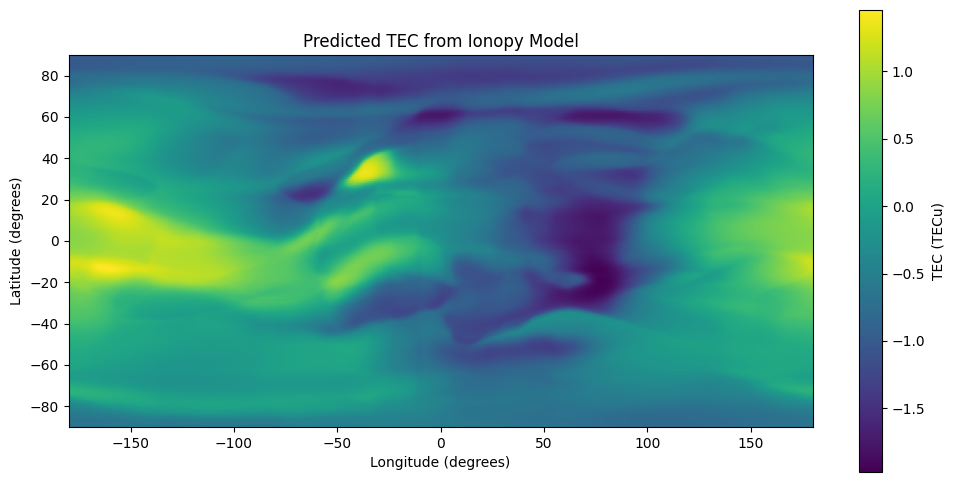

In [ ]:
#let's plot the meshgrid and targets:
targets=np.stack(targets)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.imshow(targets, extent=(-180, 180, -90, 90), cmap
='viridis', origin='lower')
plt.colorbar(label='TEC [normalized]')
plt.title('Predicted TEC from Ionopy Model')
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.show()